In [ ]:
pip install boruta


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install -U imbalanced-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached imbalanced_learn-0.9.1-py3-none-any.whl (199 kB)


# Importo librerie

###Nella prima parte di codice verranno importati i pacchetti che serviranno per effettuare analisi statistiche e di machine learning.

In [ ]:
import statistics
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid', font_scale=1.4)
from boruta import BorutaPy
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import chi2_contingency  #per test chi quadro

'''
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils

import tensorflow
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
'''

'\nfrom keras.wrappers.scikit_learn import KerasClassifier\nfrom keras.utils import np_utils\n\nimport tensorflow\nfrom tensorflow.keras import Sequential\nfrom tensorflow.keras.layers import Dense, Dropout\nfrom tensorflow.keras.callbacks import EarlyStopping\n'

### Il primo step delle analisi è quello di caricare il dataset csv tramite la funzione specifica che si può trovare sul pacchetto pandas: 

Il codice è stato sviluppato in google colab, in modo da essere maggiormente condiviso fra i partecipanti delle analisi.


A questo scopo deve essere importato il pacchetto drive di google colab e successivamente montata la directory dove è presente il file.csv che abbiamo preso in analisi

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/heart_2020_cleaned.csv")

### Visualizzazione primaria dell'head del dataset

In [ ]:
df = pd.DataFrame(df)
pd.set_option('display.max_row', df.shape[0] + 1)

print(df.head())

  HeartDisease    BMI Smoking AlcoholDrinking Stroke  PhysicalHealth  \
0           No  16.60     Yes              No     No             3.0   
1           No  20.34      No              No    Yes             0.0   
2           No  26.58     Yes              No     No            20.0   
3           No  24.21      No              No     No             0.0   
4           No  23.71      No              No     No            28.0   

   MentalHealth DiffWalking     Sex  AgeCategory   Race Diabetic  \
0          30.0          No  Female        55-59  White      Yes   
1           0.0          No  Female  80 or older  White       No   
2          30.0          No    Male        65-69  White      Yes   
3           0.0          No  Female        75-79  White       No   
4           0.0         Yes  Female        40-44  White       No   

  PhysicalActivity  GenHealth  SleepTime Asthma KidneyDisease SkinCancer  
0              Yes  Very good        5.0    Yes            No        Yes  
1       

### Descrizione primaria del dataset

In [ ]:
print(df.info())
print(df.describe())
print(df.shape)
print("\n")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319795 entries, 0 to 319794
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   HeartDisease      319795 non-null  object 
 1   BMI               319795 non-null  float64
 2   Smoking           319795 non-null  object 
 3   AlcoholDrinking   319795 non-null  object 
 4   Stroke            319795 non-null  object 
 5   PhysicalHealth    319795 non-null  float64
 6   MentalHealth      319795 non-null  float64
 7   DiffWalking       319795 non-null  object 
 8   Sex               319795 non-null  object 
 9   AgeCategory       319795 non-null  object 
 10  Race              319795 non-null  object 
 11  Diabetic          319795 non-null  object 
 12  PhysicalActivity  319795 non-null  object 
 13  GenHealth         319795 non-null  object 
 14  SleepTime         319795 non-null  float64
 15  Asthma            319795 non-null  object 
 16  KidneyDisease     31

### Grafico per la visualizzazione del numero di soggetti affetti da malattia cardiache e non

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


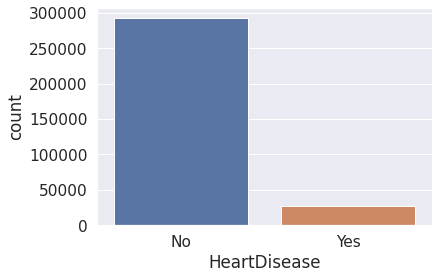

In [ ]:
sns.countplot(df['HeartDisease'])
plt.show()

# Semplificazione dei dati per ottenere un dataset bilanciato

In [ ]:
df = df.sample(frac=1)
positive_df = df.loc[df['HeartDisease'] == 'Yes']
negative_df = df.loc[df['HeartDisease'] == 'No'][0:27373]
normal_distrbuted_df = pd.concat([positive_df, negative_df])
df = normal_distrbuted_df.sample(frac = 1, random_state = 42)
df.head()
print('Distribution of the Classes in the subsample dataset')
print(df['HeartDisease'].value_counts()/len(df))

Distribution of the Classes in the subsample dataset
Yes    0.5
No     0.5
Name: HeartDisease, dtype: float64


### Reset degli indici del dataset

In [ ]:
df.reset_index(inplace = True,drop = True)

### Funzione che conta il numero delle cause di malattie cardiovascolari 

In [ ]:
def find(dataset, argomento, indice):
    c = 0
    for v in dataset[indice]:
        if v == argomento:
            c += 1
    return c

#filtro del dataset per persone affette da malattie cardiache e non

In [ ]:
df_main_heart_disease = df[df['HeartDisease'].str.contains('Yes')]
nhd = df[df['HeartDisease'].str.contains('No')]

#ricavo informazioni di correlazione 

In [ ]:
print("Il numero di persone affette da malattie cardiache che fumano sono",find(df_main_heart_disease, 'Yes', 'Smoking'))
print("Il numero di persone affette da malattie cardiache che assumono alcol sono",find(df_main_heart_disease, 'Yes', 'AlcoholDrinking'))
print("Il numero di persone affette da malattie cardiache che non fanno attività fisica sono",find(df_main_heart_disease, 'No', 'PhysicalActivity'))
print("Il numero di persone affette da malattie cardiache che hanno anche problemi epatici sono",find(df_main_heart_disease, 'Yes', 'KidneyDisease'))



print("La media dell'indice di massa corporea delle persone affette da problemi cardiaci è circa", round(df_main_heart_disease['BMI'].mean()),",")
print("mentre la media dell'indice di massa corporea delle persone che non hanno problemi cardiaci è circa", round(nhd['BMI'].mean()))
print("La media dei giorni, rispetto ai 30 precedenti alle domande, in cui lo stato di salute fisica delle persone affette da problemi cardiaci\n"
      "non è stato ottimale è circa", round(df_main_heart_disease['PhysicalHealth'].mean()),",")
print("mentre nelle persone che non hanno problemi cardiaci è circa", round(nhd['PhysicalHealth'].mean()))
print("La media dei giorni, rispetto ai 30 precedenti alle domande, in cui lo stato salute mentale delle persone affette da problemi cardiaci\n non è stato ottimale è circa", round(df_main_heart_disease['MentalHealth'].mean()),",")
print("mentre nelle persone che non hanno problemi cardiaci è circa", round(nhd['MentalHealth'].mean()))
print("La media delle ore di sonno dormite dalle persone affette da problemi cardiaci è circa",round(df_main_heart_disease['SleepTime'].mean()),",")
print("mentre dalle persone che non hanno problemi cardiaci è circa", round(nhd['SleepTime'].mean()))



Il numero di persone affette da malattie cardiache che fumano sono 16037
Il numero di persone affette da malattie cardiache che assumono alcol sono 1141
Il numero di persone affette da malattie cardiache che non fanno attività fisica sono 9884
Il numero di persone affette da malattie cardiache che hanno anche problemi epatici sono 3455
La media dell'indice di massa corporea delle persone affette da problemi cardiaci è circa 29 ,
mentre la media dell'indice di massa corporea delle persone che non hanno problemi cardiaci è circa 28
La media dei giorni, rispetto ai 30 precedenti alle domande, in cui lo stato di salute fisica delle persone affette da problemi cardiaci
non è stato ottimale è circa 8 ,
mentre nelle persone che non hanno problemi cardiaci è circa 3
La media dei giorni, rispetto ai 30 precedenti alle domande, in cui lo stato salute mentale delle persone affette da problemi cardiaci
 non è stato ottimale è circa 5 ,
mentre nelle persone che non hanno problemi cardiaci è circa 4

# Istogramma di correlazione tra presenza di malattie cardiache e indice di massa corporea

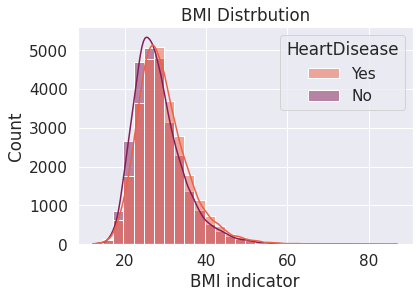

In [ ]:
sns.histplot(data=df, x='BMI', hue='HeartDisease', binwidth=2.5, kde=True, palette= 'rocket_r')
plt.title('BMI Distrbution')
plt.xlabel('BMI indicator')
plt.show()

Abbiamo usato la funzione histplot per custruire l'istogramma da cui si evidenzia come a un indice BMI più basso corrisponde un numero minore di individui affetti da patologie cardiache rispetto alle persone sane.


#Grafici a barre di correlazione tra presenza di malattie cardiache e i diversi fattori del database

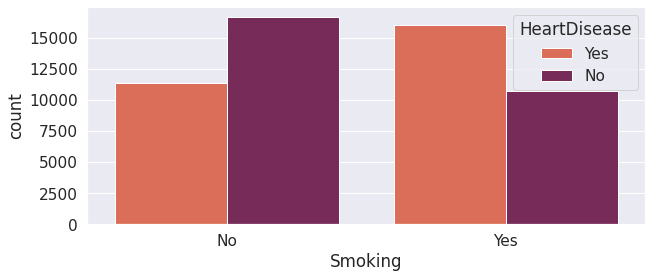

In [ ]:
plt.figure(figsize=(10,4))
sns.countplot(data=df, x='Smoking', hue='HeartDisease', palette= 'rocket_r')
plt.show()

Istogramma di correlazione tra fumatori e non ed insorgenza di malattie cardiache.


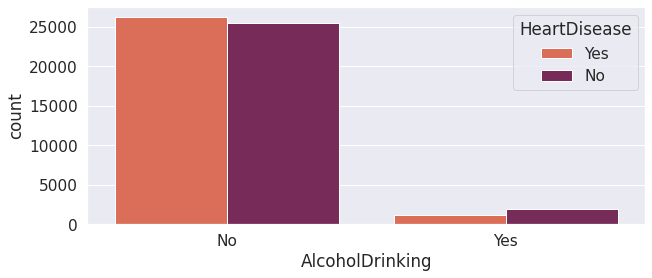

In [ ]:
plt.figure(figsize=(10,4))
sns.countplot(data=df, x='AlcoholDrinking', hue='HeartDisease', palette= 'rocket_r')
plt.show()

Istogramma di correlazione tra alcohol drinking e presenza di malattie cardiache. 

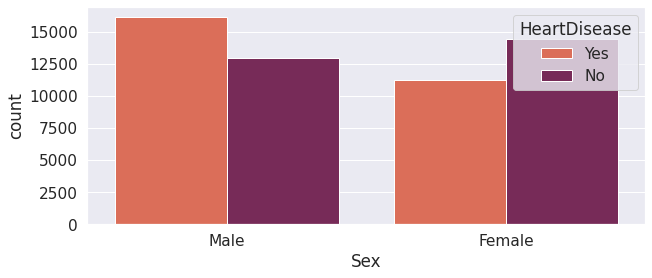

In [ ]:
plt.figure(figsize=(10,4))
sns.countplot(data=df, x='Sex', hue='HeartDisease', palette= 'rocket_r')
plt.show()

Istogramma di correlazione tra la differenza di genere della popolazione ed insorgenza di patologie cardiache.


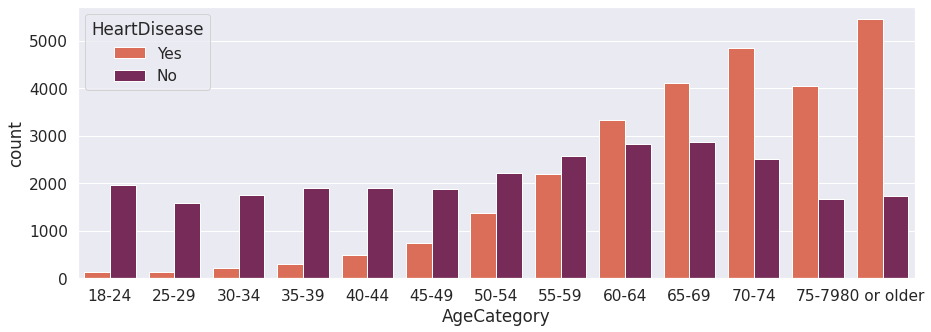

In [ ]:
plt.figure(figsize=(15,5))
sns.countplot(data=df, x='AgeCategory', hue='HeartDisease', order = df['AgeCategory'].sort_values().unique(), palette= 'rocket_r')
plt.show()

Istogramma di correlazione tra età ed insorgenza di patologie cardiahce (sono direttamente proporzionali, all'aumentare dell'età aumenta anche il rischio di sviluppare una suddetta malattia.

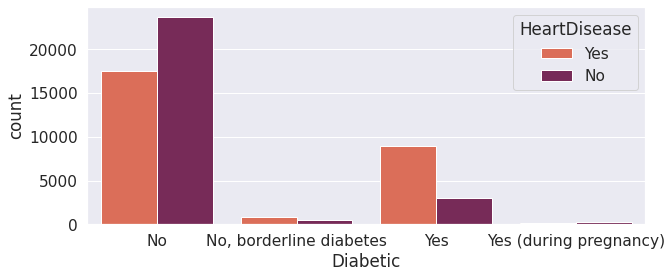

In [ ]:
plt.figure(figsize=(10,4))
sns.countplot(data=df, x='Diabetic', hue='HeartDisease', order = df['Diabetic'].sort_values().unique(), palette= 'rocket_r')
plt.show()

Istogramma di correlazione tra sviluppo di malattie cardiache e presenza di diabete. Coloro che presentano diabete sono più predisposti allo sviluppo di problemi al cuore.


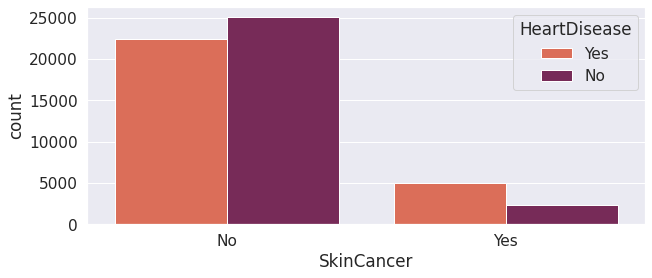

In [ ]:
plt.figure(figsize=(10,4))
sns.countplot(data=df, x='SkinCancer', hue='HeartDisease', order = df['SkinCancer'].sort_values().unique(), palette= 'rocket_r')
plt.show()

Istogramma di correlazione tra patologie cardiache e tumore alla pelle.

### Grafico a torta per visualizzazione del database per ore di sonno

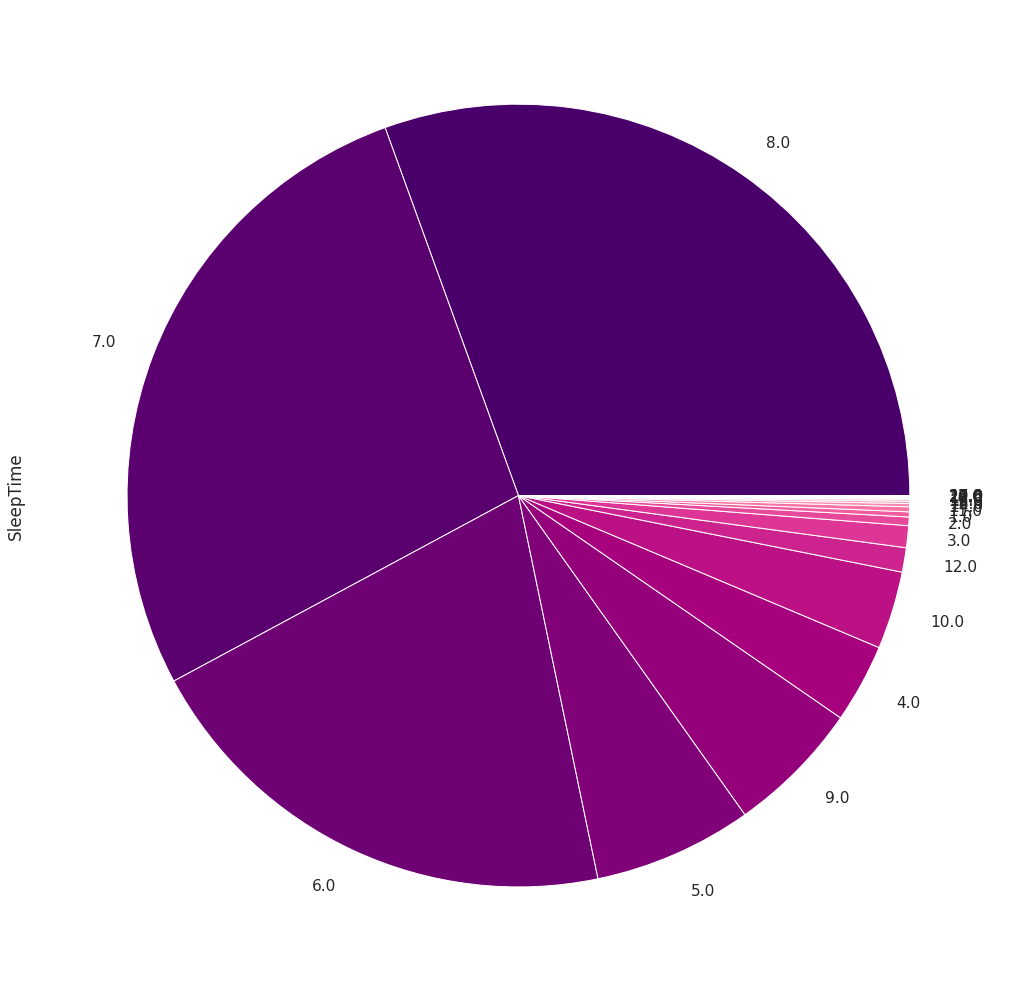

In [ ]:

df['SleepTime'].value_counts().plot(kind='pie', figsize=(18,18), cmap= 'RdPu_r')


### FUNZIONI STATISTICHE SUL DATASET FILTRATO
deviazione standard dei valori di persone affette da malattie cardiache

In [ ]:
print("L'indice di massa corporea del campione di persone affette da malattie cardiache si discosta dalla media di", statistics.pstdev(df_main_heart_disease['BMI']))
print("Il numero di ore di sonno dormite del campione di persone affette da malattie cardiache si discosta dalla media di", statistics.pstdev(df_main_heart_disease['SleepTime']))
print("Il numero di giorni in cui la salute mentale dei pazienti non è "
      "stata ottimale nel campione di persone affette da malattie cardiache si discosta dalla media di", statistics.pstdev(df_main_heart_disease['MentalHealth']))
print("Il numero di giorni in cui la salute fisica dei pazienti non è "
      "stata ottimale nel campione di persone affette da malattie cardiache si discosta dalla media di", statistics.pstdev(df_main_heart_disease['PhysicalHealth']))



L'indice di massa corporea del campione di persone affette da malattie cardiache si discosta dalla media di 6.5770306497203315
Il numero di ore di sonno dormite del campione di persone affette da malattie cardiache si discosta dalla media di 1.7808303338036158
Il numero di giorni in cui la salute mentale dei pazienti non è stata ottimale nel campione di persone affette da malattie cardiache si discosta dalla media di 9.171764051863725
Il numero di giorni in cui la salute fisica dei pazienti non è stata ottimale nel campione di persone affette da malattie cardiache si discosta dalla media di 11.487609192871295


### Trasformiamo le variabili binarie presenti in formato alfabetico in un formato numerico

Le **variabili** presenti come *SI*/*NO* all'interno del dataset sono state trasformate in variabili **binarie** (SI : 1 - NO: 0) in modo che esse possano essere utilizzate all'interno del modello di apprendimento automatico

In [ ]:
columns = ["HeartDisease", "Smoking", "AlcoholDrinking", "Stroke", "DiffWalking", "PhysicalActivity", "Asthma", "KidneyDisease", "SkinCancer"]
df[columns] = df[columns].apply(lambda x: x.map({'Yes':1,'No':0}))


Le **variabili** del dataset presenti in formato alfabetico sono state trasformate in variabili numeriche mediante l'utilizzo della funzione Label encoder presente all'interno del pacchetto **"preprocessing"** della libreria di **"sklearn"**

In [ ]:
label_encoder = preprocessing.LabelEncoder()
df['Diabetic'] = label_encoder.fit_transform(df['Diabetic'])
df['Sex'] = label_encoder.fit_transform(df['Sex'])
df['AgeCategory'] = label_encoder.fit_transform(df['AgeCategory'])
df['Race'] = label_encoder.fit_transform(df['Race'])
df['GenHealth'] = label_encoder.fit_transform(df['GenHealth'])

### Pubblichiamo in questo caso un grafico che mette in correlazione tutte le varie features fra di loro tramite il pacchetto seaborn

Utilizzando la libreria **"Seaborn"** abbiamo costruito una heatmap di ogni variabile del dataset utilizzando la funzione *heatmap* in modo da vedere la correlazione fra le variabili. 

Il colore più scuro nella heatmap definisce le variabili maggiormente correlate, mentre quello più chiaro quelle meno correlate.



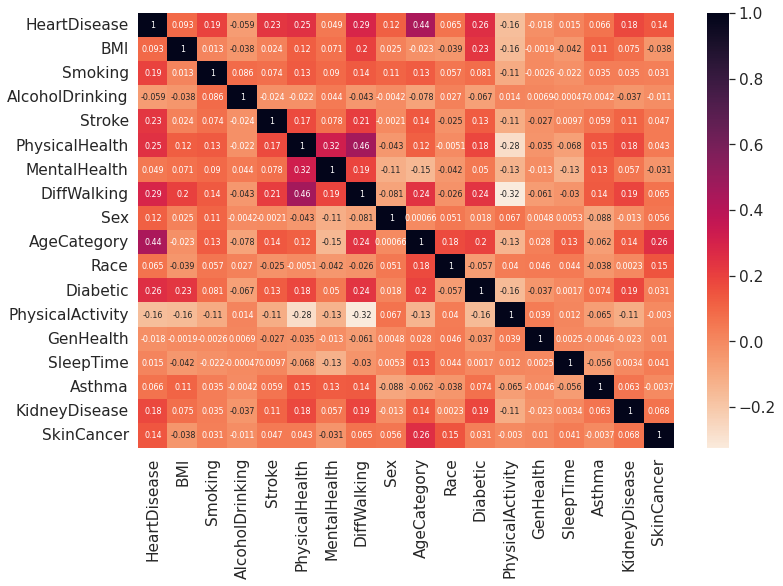

In [ ]:
plt.figure(figsize = (12,8))
sns.heatmap(df.corr(), annot = True, cmap= 'rocket_r', annot_kws={"size":8})
plt.show()


Dal grafico sopra si nota in maniera evidente come vi sia un'elevata correlazione fra *DiffWalking* (quanto una persona cammina) e *PhysicalHealth* (salute fisica) confermando questa già nota correlazione.


**Test del chi_2**

Crosstab genera una tabella di contingenza con le frequenze incrociate dei dati passati in argomento

In [ ]:
cross_HeartDisease = pd.crosstab(df["HeartDisease"], df["Stroke"])
cross_HeartDisease

Stroke,0,1
HeartDisease,,
0,26656,717
1,22984,4389


Tabella di contingenza tra ictus e malattie cardiache.

In [ ]:
chi2_contingency(cross_HeartDisease)

(2910.774615168895, 0.0, 1, array([[24820.,  2553.],
        [24820.,  2553.]]))

Il secondo valore è il p-value, se è meno di 0.05 è significativo, cioè le variabili che stiamo guardando sono dipendenti. 
chi2_contingency restituisce anche un array di valori attesi che non dovrebbero essere molto diversi da quelli osservati.

Questo test ci suggerisce che le variabili sono quindi dipendenti.

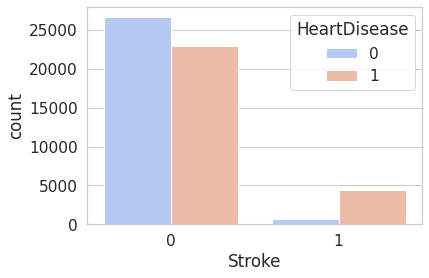

In [ ]:
sns.set_style('whitegrid')
sns.countplot(x='Stroke',data=df,hue='HeartDisease',palette='coolwarm')

Rappresentazione grafica tramite istogramma della tabella di contingenza tra ictus e patologie cardiache.

In [ ]:
cross_HeartDisease_2 = pd.crosstab(df["HeartDisease"], df["Asthma"])
cross_HeartDisease_2

Asthma,0,1
HeartDisease,,
0,23758,3615
1,22440,4933


Tabella di contingenza tra individui affetti o meno da asma e insorgenza di patologie cardiache.

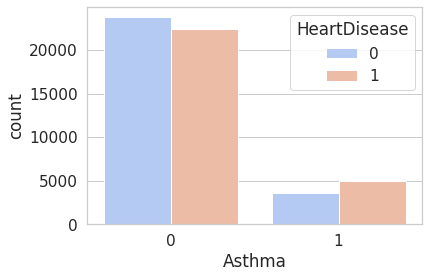

In [ ]:
sns.set_style('whitegrid')
sns.countplot(x='Asthma',data=df,hue='HeartDisease',palette='coolwarm')

Rappresentazione attraverso istogramma della tabella di contingenza tra individui affetti o meno da asma e malattie cardiache.

In [ ]:
chi2_contingency(cross_HeartDisease_2)

(240.4563525044273, 3.127524325038909e-54, 1, array([[23099.,  4274.],
        [23099.,  4274.]]))

In [ ]:
cross_HeartDisease_3 = pd.crosstab(df["HeartDisease"], df["PhysicalActivity"])
cross_HeartDisease_3

PhysicalActivity,0,1
HeartDisease,,
0,5807,21566
1,9884,17489


Tabella di contingenza di individui che praticano o meno attività fisica e presenza di problemi cardiaci. 

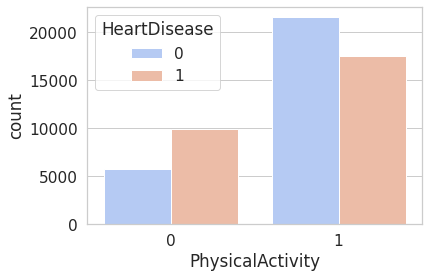

In [ ]:
sns.set_style('whitegrid')
sns.countplot(x='PhysicalActivity',data=df,hue='HeartDisease',palette='coolwarm')

Rapresentazione grafica attraverso istogramma della tabella di contingenza di individui che praticano o meno attività fisica e insorgenza di patologie cardiache.

In [ ]:
chi2_contingency(cross_HeartDisease_3)

(1484.2035950258514, 0.0, 1, array([[ 7845.5, 19527.5],
        [ 7845.5, 19527.5]]))

# Nella prima parte di codice sono stati importati i pacchetti che serviranno per effettuare analisi machine learning


Inizialmente vanno importati i pacchetti che vengono utilizzati per le analisi di **machine learning**.

Pandas è un pacchetto utile per quanto riguarda la gestione e l'analisi dei dataset.

NumPy è un pacchetto utile per la gestione di Array all'interno di Python


Sklearn proviene da Sci-kit learn e contiene una serie di pacchetti importanti per quanto riguarda l'analisi di apprendimento automatico (ad esempio contiene la funzione di Random Forest classifier o di train test split)


Matplotlib viene utilizzato per la parte grafica di Python in quanto permette di visualizzare dal punto di vista grafico i dati 

Seaborn è un pacchetto che viene utilizzato per la gestione grafica dei dati.

# Esperimenti con il Machine Learning

Il primo step delle analisi è quello di caricare il dataset csv tramite la funzione specifica che si può trovare sul pacchetto pandas:
Il codice è stato sviluppato in google colab, in modo da essere maggiormente condiviso fra i partecipanti delle analisi.

A questo scopo deve essere importato il pacchetto drive di google colab e successivamente montata la directory dove è presente il file.csv che abbiamo preso in analisi

Trasformiamo le variabili binarie presenti in formato alfabetico in un formato numerico
Le variabili presenti come SI/NO all'interno del dataset sono state trasformate in variabili binarie (SI : 1 - NO: 0) in modo che esse possano essere utilizzate all'interno del modello di apprendimento automatico

Le **variabili** del dataset presenti in formato alfabetico sono state trasformate in variabili numeriche mediante l'utilizzo della funzione Label encoder presente all'interno del pacchetto **"preprocessing"** della libreria di **"sklearn"**

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/heart_2020_cleaned.csv")

# Variabili binarie in formato alfabetico trasformate in formato numerico
columns = ["HeartDisease", "Smoking", "AlcoholDrinking", "Stroke", "DiffWalking", "PhysicalActivity", "Asthma", "KidneyDisease", "SkinCancer"]
df[columns] = df[columns].apply(lambda x: x.map({'Yes':1,'No':0}))

# Variabili non binarie in formato alfabetico sono trasformate in formato numerico
label_encoder = preprocessing.LabelEncoder()
df['Diabetic'] = label_encoder.fit_transform(df['Diabetic'])
df['Sex'] = label_encoder.fit_transform(df['Sex'])
df['AgeCategory'] = label_encoder.fit_transform(df['AgeCategory'])
df['Race'] = label_encoder.fit_transform(df['Race'])
df['GenHealth'] = label_encoder.fit_transform(df['GenHealth'])

## Divisione del dataset

La target label (**heart disease**) viene salvata su una lista **Y** in modo da essere successivamente utilizzata come variabile target per le analisi di Machine Learning, e dunque essa deve essere rimossa dal dataset X, che viene utilizzato come dataset di training e testing per le analisi di machine learning.


In [ ]:
X = df.drop('HeartDisease', axis = 1)
y = df['HeartDisease']

Dividiamo il dataset delle analisi in 2 dataset separati: **Training/Test set** che serviranno successivamente per le analisi di machine learning, utilizzando una funzione di scikit learn chiamata *train_test_split* che permette di dividere il dataset in maniera casuale fra training e testing.

In questo caso abbiamo deciso di scegliere come dimensione del testing set 0.25 in quanto è un valore di default nelle analisi di machine learning.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.25, random_state = 42)

Su tutto il dataset applichiamo il classificatore **Regressione Logistica** su tutte le features presenti nelle analisi, mostrando lo score di accuratezza ottenuto e il classification report. 

Quest'ultimo ci darà informazioni su precision,recall ed f1-score del modello.


**Accuracy**: Definisce i dati correttamente classificati sul totale dei dati.


**Precision**: la proporzione delle identificazioni positive che sono realmente corrette: un modello che produce zero falsi positivi ha una precisione di 1.

**Recall**: la proporzione dei veri positivi che sono correttamente classificati: un modello che produce zero falsi negativi ha un recall di 1.

**F1-Score**: Combinazione di *Precision* e *Recall*: un modello perfetto raggiunge un F1-Score di 1.

**Weighted Average**: Media pesata di precisione, recall e F1-Score fra le classi. Questa metrica è calcolata tenendo conto di quanti campioni ci sono in ogni classe.

**Macro Average**: media aritmetica della singola classe relativa a precisione, recall e f1-score


---


## Regressione Logistica

Una volta definito il classificatore posso procedere a effettuare il training del modello sul training set. Questo step mi permette di ottenere un modello che riesca a riconoscere in modo accurato la variabile target (**Y**) basandosi sulle variabili del dataset (**X**).

Una volta effettuato il *Training* del modello, andremo a valutare la sua accuratezza sul *set di testing*. 

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

model = LogisticRegression(max_iter=300)
model.fit(X_train, y_train)
y_pred_LR = model.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred_LR))


Accuracy: 0.9135824087856008


### Curva ROC

Una volta ottenuta l'accuratezza del modello sul *testing set*, possiamo costruire la curva ROC (**Receiver Operating Characteristic**), una misura statistica altamente utilizzata nelle analisi mediche per definire la performance del classificatore in termini di AUC (**Area under the curve**).

L'AUC è una misura di accuratezza, e viene definita calcolando l'area sotto la 
curva ROC.


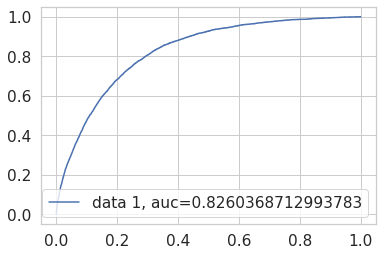

In [ ]:
y_pred_proba = model.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.savefig("LR_disp.png",dpi=100)
plt.show()

Per osservare meglio la performance, dunque il risultato del classificatore da noi implementato, abbiamo utilizzato un pacchetto (**Confusion Matrix**) presente nella libreria *scikit-learn metrics* il quale permette di costruire una matrice di confusione che riassume la performance del classificatore sulla predizione delle variabili target (**Y**) sul testing set, consentendoci di visualizzare gli errori commessi dal nostro modello. 


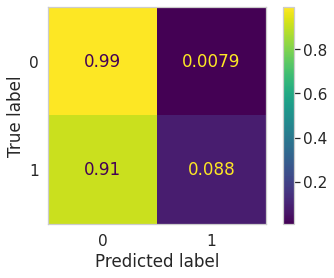

              precision    recall  f1-score   support

           0       0.92      0.99      0.95     73004
           1       0.52      0.09      0.15      6945

    accuracy                           0.91     79949
   macro avg       0.72      0.54      0.55     79949
weighted avg       0.88      0.91      0.88     79949



0.9135824087856008

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

nn=confusion_matrix(y_test, y_pred_LR, normalize='true')
cm_display = ConfusionMatrixDisplay(nn).plot()
plt.savefig("Confusion_Matrix_LR.png",dpi=100)
plt.grid(b=None)
plt.show()

accuracy_score(y_test, y_pred_LR)
print(classification_report(y_test, y_pred_LR))
model.score(X_test, y_test)

Come si evince dal grafico ci sono tantissimi falsi negativi. 

Questo errore nella predizione delle persone con *Heart Disease* è causato da un dataset sbilanciato verso le *persone sane*, ossia le persone sane sono presenti in maggior numero rispetto alle persone aventi malattie cardiologiche.

Questo sbilanciamento presenta un problema durante le analisi di **Supervised Machine Learning**, in quanto esse utilizzano il dataset **x** per migliorare l'accuratezza favorendo in questo caso la corretta predizione delle persone senza malattie cardiologiche


Per ovviare a questo problema, abbiamo provato la tecnica dell'under sampling, la quale permette di sottodimensionare la classe di persone sane, consentendoci di ottenere un dataset bilanciato, su cui successivamente vengono svolte le analisi di classificazione tramite **Regressione Logistica**.



## Data Preprocessing

### Random under sampling dei dati

Per effettuare l'Under Sampling dei dati, abbiamo utilizzato il pacchetto (*RandomUnderSampler*) dalla libreria **Imblearn**, e lo abbiamo effettuato sia sul training che sul testing set

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter


# RUS del train set
rus = RandomUnderSampler(random_state=42) #rus -> random under sampler
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)
X_test_rus, y_test_rus= rus.fit_resample(X_test, y_test)

print(f"Training set passato da {list(Counter(y_train).items())} elementi a {list(Counter(y_train_rus).items())} elementi")
print(f"Test set passato da {list(Counter(y_test).items())} elementi a {list(Counter(y_test_rus).items())} elementi")

Training set passato da [(0, 219418), (1, 20428)] elementi a [(0, 20428), (1, 20428)] elementi
Test set passato da [(0, 73004), (1, 6945)] elementi a [(0, 6945), (1, 6945)] elementi


Una volta effettuato l'Undersampling, abbiamo riprovato le analisi di classificazione utilizzando la **Regressione Logistica** come classificatore, ricalcolando le metriche utilizzate in precedenza e costruendo i grafici della matrice di confusione e della curva ROC. 



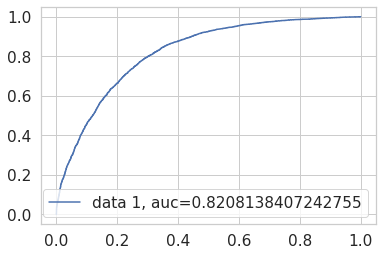

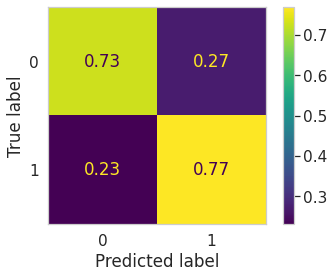

              precision    recall  f1-score   support

           0       0.76      0.73      0.74      6945
           1       0.74      0.77      0.75      6945

    accuracy                           0.75     13890
   macro avg       0.75      0.75      0.75     13890
weighted avg       0.75      0.75      0.75     13890



0.7484521238300936

In [ ]:
model = LogisticRegression(max_iter=300) 
model.fit(X_train_rus, y_train_rus)
y_pred_LR = model.predict(X_test_rus)

y_pred_proba = model.predict_proba(X_test_rus)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test_rus,  y_pred_proba)
auc = metrics.roc_auc_score(y_test_rus, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.savefig("LR_disp.png",dpi=100)
plt.show()

nn=confusion_matrix(y_test_rus, y_pred_LR, normalize='true')
cm_display = ConfusionMatrixDisplay(nn).plot()
plt.savefig("Confusion_Matrix_LR.png",dpi=100)
plt.grid(b=None)
plt.show()

accuracy_score(y_test_rus, y_pred_LR)
print(classification_report(y_test_rus, y_pred_LR))
model.score(X_test_rus, y_test_rus)

L'undersampling dei dati ci ha permesso un miglioramento nella predizione delle persone con malattie cardiache, tuttavia abbiamo provato un metodo, la **PCA**, per ridurre la dimensionalità del dataset per vedere se grazie ad essa possiamo ottenere un'accuratezza superiore. 

### PCA

La **Principal Component Analysis** è una tecnica per la semplificazione dei dati utilizzata nell’ambito della *statistica multivariata*. Essa ci permette di ridurre il numero di variabili che descrivono un insieme di dati a un numero minore di variabili latenti, limitando il più possibile la perdita di informazioni; quindi di identificare le variabili che meglio riescono a classificare i campioni.

Proviamo la PCA su tutte le componenti del training set (`n_components=X_train_rus.shape[1]`) e valutiamo dal grafico il valore ottimale di componenti per non ridurre la varianza dei dati.

Text(0, 0.5, 'Explained variance (%)')

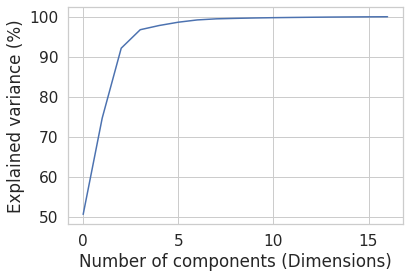

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=X_train_rus.shape[1]) 
pca.fit(X_train_rus)


plt.plot(np.cumsum(pca.explained_variance_ratio_ * 100))
plt.xlabel("Number of components (Dimensions)")
plt.ylabel("Explained variance (%)")

Dal grafico si evince che `n_components=7` è ottimale per non avere perdita di varianza sul training set. Applichiamo quindi la PCA sul dataset.

In [ ]:
pca = PCA(n_components=7) 
pca.fit(X_train_rus)

x_train_PCA = pca.fit_transform(X_train_rus)
x_test_PCA = pca.fit_transform(X_test_rus)

print(f"Training set passato da {X_train_rus.shape} elementi a {x_train_PCA.shape} elementi")
print(f"Test set passato da {X_test_rus.shape} elementi a {x_test_PCA.shape} elementi")


Training set passato da (40856, 17) elementi a (40856, 7) elementi
Test set passato da (13890, 17) elementi a (13890, 7) elementi


Applichiamo nuovamente la Regressione Logistica per valutare se i risultati (in particolare l'accuracy) migliorano dopo preprocessing dei dati con PCA.

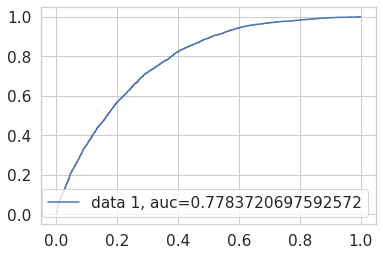

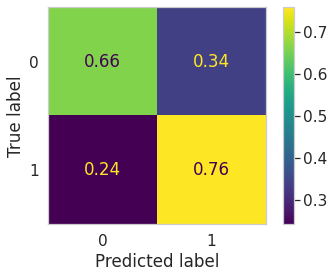

              precision    recall  f1-score   support

           0       0.73      0.66      0.69      6945
           1       0.69      0.76      0.72      6945

    accuracy                           0.71     13890
   macro avg       0.71      0.71      0.71     13890
weighted avg       0.71      0.71      0.71     13890



0.7093592512598992

In [ ]:
model = LogisticRegression(max_iter=300) 
model.fit(x_train_PCA, y_train_rus)
y_pred_LR = model.predict(x_test_PCA)

y_pred_proba = model.predict_proba(x_test_PCA)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test_rus,  y_pred_proba)
auc = metrics.roc_auc_score(y_test_rus, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.savefig("LR_disp.png",dpi=100)
plt.show()

nn=confusion_matrix(y_test_rus, y_pred_LR, normalize='true')
cm_display = ConfusionMatrixDisplay(nn).plot()
plt.savefig("Confusion_Matrix_LR.png",dpi=100)
plt.grid(b=None)
plt.show()

accuracy_score(y_test_rus, y_pred_LR)
print(classification_report(y_test_rus, y_pred_LR))
model.score(x_test_PCA, y_test_rus)

I risultati non sono migliorati. Addirittura, si nota un peggioramento complessivo delle performance, quindi si decide di non utilizzare la PCA per il preprocessing dei dati.

## Decision Tree
Procediamo con le analisi con il classificatore *Decision Tree* e utilizziamo il dataset bilanciato attraverso Random Under Sampling.



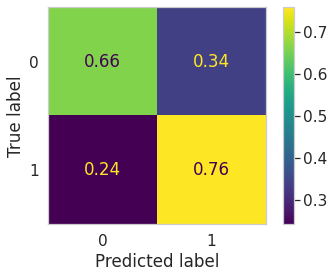

[[4655 2290]
 [2381 4564]]
              precision    recall  f1-score   support

           0       0.66      0.67      0.67      6945
           1       0.67      0.66      0.66      6945

    accuracy                           0.66     13890
   macro avg       0.66      0.66      0.66     13890
weighted avg       0.66      0.66      0.66     13890



In [ ]:
from sklearn.tree import DecisionTreeClassifier

dtc= DecisionTreeClassifier()
dtc.fit(X_train_rus, y_train_rus)
y_pred_DT =dtc.predict(X_test_rus)


cm_display = ConfusionMatrixDisplay(nn).plot()
plt.savefig("Confusion_Matrix_DT",dpi=100)
plt.grid(b=None)
plt.show()

print(metrics.confusion_matrix(y_test_rus,y_pred_DT))
print(metrics.classification_report(y_test_rus, y_pred_DT))

I risultati ottenuti con questa metodica però non sono soddisfacenti, in quanto la predizione risulta peggiore rispetto a quella ottenuta con la Regressione Logistica.

## Random Forest

Decidiamo di provare la classificazione attraverso **Random Forest**, il quale è una evoluzione del classificatore precedente, per valutare se i risultati che otterremo saranno o meno migliori in termini di accuracy. 

Effettuiamo model assessment su alcuni iperparametri del Random Forest per determinare i valori migliori valutando l'accuratezza ottenuta sul test set.

Si tratta di un'**operazione costosa in termini di tempo**, per questo si è deciso di lasciare il codice seguente commentato per mostrare l'analisi eseguita in precedenza.

In [ ]:
## Model assessment iperparametri RandomForest
#estimators = [10, 50, 100, 500, 1000]
#depth = [4, 8, 16, 32]
#split = [4, 8, 16, 32]
#for est in estimators:
#  for dep in depth:
#    for spl in split:

#      clf=RandomForestClassifier(n_estimators=est,max_depth=dep,random_state=42, min_samples_split=spl)
#      clf.fit(X_train_rus,y_train_rus)
#      Y_pred=clf.predict(X_test_rus)
#      print(f"Analisi con est {est}, dep {dep}, spl {spl}")
#      accuracy_score(y_test_rus, Y_pred)
#      print(classification_report(y_test_rus, Y_pred))
#      print(f"--------------------------------")

In base alla valutazione precedente, risultano ottimali i valori ```(n_estimators=100, max_depth=8, min_samples_split=4)```, che riportiamo nell'esecuzione del modello Random Forest nel codice seguente.



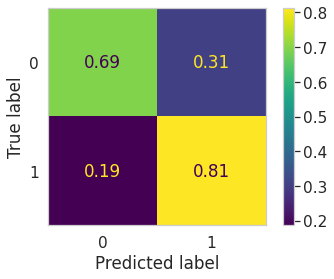

              precision    recall  f1-score   support

           0       0.79      0.69      0.74      6945
           1       0.73      0.81      0.77      6945

    accuracy                           0.75     13890
   macro avg       0.76      0.75      0.75     13890
weighted avg       0.76      0.75      0.75     13890



In [ ]:
clf=RandomForestClassifier(n_estimators=100,max_depth=8,random_state=42, min_samples_split=4)
clf.fit(X_train_rus,y_train_rus)
Y_pred=clf.predict(X_test_rus)

nn=confusion_matrix(y_test_rus, Y_pred, normalize='true')
cm_display = ConfusionMatrixDisplay(nn).plot()
plt.savefig("Confusion_Matrix_RandomForest.png",dpi=100)
plt.grid(b=None)
plt.show()

accuracy_score(y_test_rus, Y_pred)
print(classification_report(y_test_rus, Y_pred))

I risultati, in termini di accuratezza, sembrano effettivamente essere migliori.

Per ulteriore conferma, testiamo Random Forest con il dataset preprocessato con la PCA.

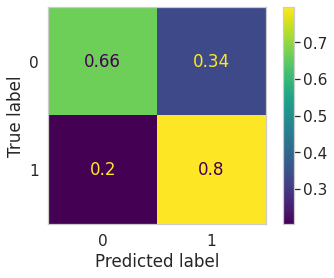

              precision    recall  f1-score   support

           0       0.77      0.66      0.71      6945
           1       0.70      0.80      0.75      6945

    accuracy                           0.73     13890
   macro avg       0.74      0.73      0.73     13890
weighted avg       0.74      0.73      0.73     13890



In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf=RandomForestClassifier(n_estimators=100,max_depth=8, min_samples_split=4,random_state=4242)
clf.fit(x_train_PCA, y_train_rus)
Y_pred=clf.predict(x_test_PCA)

nn=confusion_matrix(y_test_rus, Y_pred, normalize='true')
cm_display = ConfusionMatrixDisplay(nn).plot()
plt.savefig("Confusion_Matrix_RandomForest.png",dpi=100)
plt.grid(b=None)
plt.show()

accuracy_score(y_test_rus, Y_pred)
print(classification_report(y_test_rus, Y_pred))

Come già visto sperimentalmente con la Regressione Logistica, anche con il Random Forest il preprocessing dei dati con la PCA non porta miglioramenti in termini di accuratezza sul test set. Da ora in poi non utilizzeremo più i dati pre-processati con PCA.

## K-Nearest Neighbors (KNN)
**K-Nearest Neighbors** è un classificatore di apprendimento supervisionato non parametrico, che utilizza la prossimità per effettuare classificazioni o previsioni sul raggruppamento di un singolo punto dati.

Procediamo effettuando nuovamente le analisi andando a impiegare come classificatore KNN.

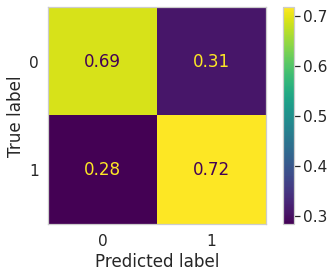

              precision    recall  f1-score   support

           0       0.71      0.69      0.70      6945
           1       0.70      0.72      0.71      6945

    accuracy                           0.70     13890
   macro avg       0.70      0.70      0.70     13890
weighted avg       0.70      0.70      0.70     13890



In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
#training del modello
knn.fit(X_train_rus, y_train_rus)
#predizione
pred_KN = knn.predict(X_test_rus)

nn=confusion_matrix(y_test_rus, pred_KN, normalize='true')
cm_display = ConfusionMatrixDisplay(nn).plot()
plt.savefig("Confusion_Matrix_KN.png",dpi=100)
plt.grid(b=None)
plt.show()

accuracy_score(y_test_rus, pred_KN)
print(classification_report(y_test_rus, pred_KN))

Per sapere quale è il miglior valore di K, facciamo il model assessment e proviamo in seguito a utilizzare l'**elbow method**.

Prima creiamo un *for loop* che ci fa il training di vari modelli KNN con diversi valori di K, tenendo traccia dell'`error_rate` per ciascuno di questi modelli con un elenco.

Come prima, poiché la valutazione del modello è un'operazione dispendiosa in termini di tempo, lasciamo commentata questa parte di codice.

In [ ]:
#error_rate=[]

#for i in range(1,40):
#  knn = KNeighborsClassifier(n_neighbors=i)
#  knn.fit(X_train_rus,y_train_rus)
#  pred_i = knn.predict(X_test_rus)
#  error_rate.append(np.mean(pred_i != y_test_rus))
#  print(f"Analisi con n_neighbors={i} completata, error_rate={error_rate[i-30]}")

Usiamo i dati ottenuti in precedenza per costruire un grafico dell'error_rate e stampiamo il valore di K che risulta avere il minor error_rate.

Minimum error:- 0.26767458603311733 at K = 27


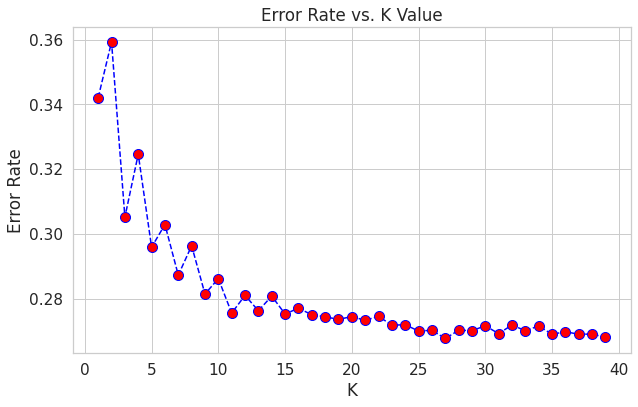

In [ ]:
# SE elbow method non viene eseguito, error_rate resta indefinito, verrà chiamata eccezione NameError si possono quindi usare valori salvati da precedente analisi per stampare comunque il grafico

try:
    error_rate
    if error_rate is None or len(error_rate) ==0:
      raise NameError("error_rate not defined or empty")
except NameError:
  error_rate = [0.34211663066954645, 0.3593232541396688, 0.30518358531317497, 0.324622030237581, 0.2958963282937365, 0.30287976961843055, 0.28725701943844495, 0.2963282937365011, 0.2814254859611231, 0.2861771058315335, 0.2755219582433405, 0.2809935205183585, 0.2762419006479482, 0.28077753779697623, 0.27523398128149745, 0.27703383729301656, 0.2750179985601152, 0.27437005039596835, 0.2735781137508999, 0.27444204463642907, 0.2732901367890569, 0.27451403887688985, 0.27177825773938086, 0.27192224622030237, 0.26997840172786175, 0.27019438444924404, 0.26767458603311733, 0.27019438444924404, 0.2701223902087833, 0.27156227501799857, 0.26918646508279337, 0.27185025197984164, 0.27005039596832253, 0.27156227501799857, 0.2689704823614111, 0.26976241900647946, 0.2689704823614111, 0.26904247660187186, 0.2680345572354212]

plt.figure(figsize=(10,6))
plt.plot(range(1,40),error_rate,color='blue', linestyle='dashed', 
         marker='o',markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')
print("Minimum error:-",min(error_rate),"at K =",error_rate.index(min(error_rate))+1)

Effettuiamo il training del modello la predizione; e infine valutiamo la sua accuratezza sul test set con K=27.

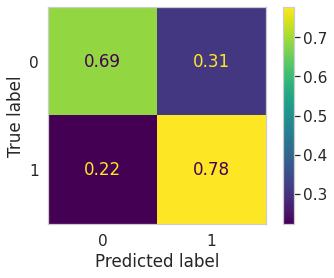

              precision    recall  f1-score   support

           0       0.76      0.69      0.72      6945
           1       0.71      0.78      0.74      6945

    accuracy                           0.73     13890
   macro avg       0.73      0.73      0.73     13890
weighted avg       0.73      0.73      0.73     13890



In [ ]:
knn = KNeighborsClassifier(n_neighbors=27)
#training del modello
knn.fit(X_train_rus, y_train_rus)
#predizione
pred_KN = knn.predict(X_test_rus)

nn=confusion_matrix(y_test_rus, pred_KN, normalize='true')
cm_display = ConfusionMatrixDisplay(nn).plot()
plt.savefig("Confusion_Matrix_KN.png",dpi=100)
plt.grid(b=None)
plt.show()

accuracy_score(y_test_rus, pred_KN)
print(classification_report(y_test_rus, pred_KN))

L'accuracy è buona, un po' sotto il risultato ottenuto con Regressione Logistica.



## Multi Layer Perceptron

MLP è un tipo di rete neurale artificiale (ANN) ed è considerato il primo modello di *Deep Learning*. L'MLP più semplice è costituito da almeno tre livelli di nodi: un livello di input, un livello nascosto e un livello di output.

In questo caso sono stati inseriti due livelli nascosti: `hidden_layer_sizes=(32,16)`. Vediamo i risultati.

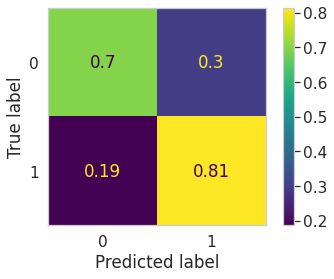

              precision    recall  f1-score   support

           0       0.79      0.70      0.74      6945
           1       0.73      0.81      0.77      6945

    accuracy                           0.76     13890
   macro avg       0.76      0.76      0.76     13890
weighted avg       0.76      0.76      0.76     13890



In [ ]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(hidden_layer_sizes=(32,16),activation="relu",random_state=42, max_iter=200).fit(X_train_rus, y_train_rus)
pred_MLP=clf.predict(X_test_rus)

nn=confusion_matrix(y_test_rus, pred_MLP, normalize='true')
cm_display = ConfusionMatrixDisplay(nn).plot()
plt.savefig("Confusion_Matrix_MLP.png",dpi=100)
plt.grid(b=None)
plt.show()

accuracy_score(y_test_rus, pred_MLP)
print(classification_report(y_test_rus, pred_MLP))

Il MLP risulta raggiungere, anche se di poco, i risultati migliori rispetto agli altri modelli. Molto probabilmente, aumentando il numero di hidden layers, il numero di neuroni ed il numero di iterazioni della fase di training (rispettivamente ```hidden_layer_sizes=(32,16), max_iter=200```), i risultati potrebbero migliorare ulteriormente. Ciononostante, per lo scopo di questo report, ci riteniamo soddisfatti dei risultati ottenuti in quanto ci permettono di comparare i diversi modelli e poter discutere dei risultati.

## Discussione e Conclusioni

Nella tabella sottostante abbiamo riassunto i dati principali ottenuti con RUS dalle analisi effettuate in questo report, elencando i modelli in ordine crescente per i risultati ottenuti in merito ad accuracy, precision e recall.

Si può osservare quindi che i valori di accuratezza peggiori sono stati trovati con il classificatore Decision Tree, mentre i migliori sono quelli trovati tramite Multi Layer Perceptron.

Prima di affettuare RUS, utilizzando la Regressione Logistica ottenevamo valori del tutto sbilanciati.

L'elevata numerosità dei campioni ha guidato la nostra scelta verso l'applicazione dell'Under Sampling in quanto volevamo mantenere i dati reali. L'altra possibilità era quella di effettuare lo SMOTE che permette di arrivare ad un'accuratezza più alta ma perdendo tuttavia la realtà dei risultati.

Oltre alla scelta della tecnica utilizzata per il bilanciamento dei dati, altri tre fattori che influiscono sull'analisi sono la numerosità del dataset, il modello scelto, la feature selection.


| MODELLO             	| ACCURACY 	| PRECISION 	| RECALL 	|
|---------------------	|----------	|-----------	|--------	|
| Decision Tree       	| 0.66     	| 0.66      	| 0.66   	|
| KN Neighbors        	| 0.73     	| 0.73      	| 0.73   	|
| Logistic Regression 	| 0.75     	| 0.75      	| 0.75   	|
| Random Forest       	| 0.75     	| 0.76      	| 0.75   	|
| MLP                 	| **0.76**     	| **0.76**      	| **0.76**   	|

